In [ ]:
#!pip install rectools > None

In [ ]:
#!pip install optuna > None

In [ ]:
import os

import pandas as pd
import numpy as np

import requests
from tqdm.auto import tqdm

from rectools.metrics import Precision, Recall, MAP, calc_metrics, MeanInvUserFreq, Serendipity
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from lightfm import LightFM

from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization

import optuna
import dill

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [ ]:
SEED = 2022
K_RECOS = 10
metrics = {
    "map@10": MAP(k=10),
    "recall@10": Recall(k=10),
}

## Get data

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

,user_id,item_id
0,3,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
1,11,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
2,29,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
3,30,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
4,33,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."


In [ ]:
url = "https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip"

req = requests.get(url, stream=True)

with open('kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [ ]:
#!unzip kion.zip

In [ ]:
def load_data():
  interactions = pd.read_csv('kion_train/interactions.csv')
  users = pd.read_csv('kion_train/users.csv')
  items = pd.read_csv('kion_train/items.csv')
  interactions.rename(
    columns={
        'last_watch_dt': 'datetime',
        'total_dur': 'weight',
    },
    inplace=True,
  )

  interactions['datetime'] = pd.to_datetime(interactions['datetime'])
  interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)
  return interactions, users, items

In [ ]:
interactions, users, items = load_data()
last_date = interactions['datetime'].max().normalize()

train = interactions[interactions[Columns.Datetime] < last_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= last_date - pd.Timedelta(days=7)].copy()

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (4985269, 5)
test: (490982, 5)


In [ ]:
cold_users = set(test[Columns.User]) - set(train[Columns.User])

In [ ]:
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)

## Prepare user features

In [ ]:
users.isna().sum()

user_id         0
age         14095
income      14776
sex         13831
kids_flg        0
dtype: int64

In [ ]:
users.fillna('Unknown', inplace=True)

In [ ]:
users = users.loc[users[Columns.User].isin(train[Columns.User])].copy()
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
5,1037719,age_45_54,income_60_90,М,0


In [ ]:
user_features_frames = []
for feature in ["sex", "age", "income"]:
    feature_frame = users.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)
user_features.head()

,id,value,feature
0,973171,М,sex
1,962099,М,sex
3,721985,Ж,sex
4,704055,Ж,sex
5,1037719,М,sex


## Prepare item features

In [ ]:
items.isna().sum()

item_id             0
content_type        0
title               0
title_orig       4745
release_year       98
genres              0
countries          37
for_kids        15397
age_rating          2
studios         14898
directors        1509
actors           2619
description         2
keywords          423
dtype: int64

In [ ]:
items = items.loc[items[Columns.Item].isin(train[Columns.Item])].copy()
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


### Genre

In [ ]:
items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


### Content

In [ ]:
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"
content_feature.head()

,id,value,feature
0,10711,film,content_type
1,2508,film,content_type
2,10716,film,content_type
3,7868,film,content_type
4,16268,film,content_type


### Binned release_year

In [ ]:
pd.qcut(items['release_year'], q=10).head()

0      (1983.0, 2003.0]
1      (2012.0, 2014.0]
2      (2009.0, 2012.0]
3      (2014.0, 2016.0]
4    (1896.999, 1983.0]
Name: release_year, dtype: category
Categories (10, interval[float64, right]): [(1896.999, 1983.0] < (1983.0, 2003.0] < (2003.0, 2009.0] <
                                            (2009.0, 2012.0] ... (2016.0, 2017.0] <
                                            (2017.0, 2019.0] < (2019.0, 2020.0] < (2020.0, 2021.0]]

In [ ]:
items['binned_r_year'] = pd.qcut(items['release_year'], q=10, labels=list(range(10)))

In [ ]:
release_year_feature = items.reindex(columns=[Columns.Item, "binned_r_year"])
release_year_feature.columns = ["id", "value"]
release_year_feature["feature"] = "binned_r_year"
release_year_feature.head()

,id,value,feature
0,10711,1,binned_r_year
1,2508,4,binned_r_year
2,10716,3,binned_r_year
3,7868,5,binned_r_year
4,16268,0,binned_r_year


### countries

In [ ]:
items["country"] = items["countries"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
country_feature = items[["item_id", "country"]].explode("country")
country_feature.columns = ["id", "value"]
country_feature["feature"] = "country"
country_feature.head()

,id,value,feature
0,10711,испания,country
1,2508,сша,country
2,10716,канада,country
3,7868,великобритания,country
4,16268,ссср,country


###  Combine all

In [ ]:
item_features = pd.concat((genre_feature, content_feature, country_feature, release_year_feature))
item_features[item_features['id'] == 10711]

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
0,10711,film,content_type
0,10711,испания,country
0,10711,1,binned_r_year


## Init dataset

In [ ]:
dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
    item_features_df=item_features,
    cat_item_features=["genre", "country", 'binned_r_year', 'content_type'],
)

In [ ]:
TEST_USERS = test[Columns.User].unique()

## Models

In [ ]:
def print_study_info(study):
  print("Number of finished trials: ", len(study.trials))
  print("Best trial:")
  trials = study.best_trials
  for trial in trials:
    #print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
      print("    {}: {}".format(key, value))

### ImplicitALSWrapperModel

In [ ]:
def objective_ImplicitALSWrapperModel(trial):
    n_factors = trial.suggest_int("n_factors", low=32, high=128, step=32)
    regularization = trial.suggest_float("regularization", low=0.01, high=0.51, step=0.1)
    model_obj = ImplicitALSWrapperModel(
      model=AlternatingLeastSquares(
        factors=n_factors, 
        regularization=regularization,
        random_state=SEED, 
      ),
      fit_features_together=True,
    )

    model_obj.fit(dataset)
    recos = model_obj.recommend(
      users=TEST_USERS,
      dataset=dataset,
      k=K_RECOS,
      filter_viewed=True,
    )
    metric_values = calc_metrics(metrics, recos, test, train)

    return metric_values['map@10'], metric_values['recall@10']

In [ ]:
def save_best_trial_model(trial):
    # Use same code objective to reproduce the best model
    n_factors = trial.suggest_int("n_factors", low=32, high=128, step=32)
    regularization = trial.suggest_float("regularization", low=0.01, high=0.51, step=0.1)
    model_obj = ImplicitALSWrapperModel(
      model=AlternatingLeastSquares(
        factors=n_factors, 
        regularization=regularization,
        random_state=SEED, 
      ),
      fit_features_together=True,
    )

    model_obj.fit(dataset)

    with open('implicit_als.dill', 'wb') as f:
      dill.dump(model_obj.model, f)

In [ ]:
%%time

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(objective_ImplicitALSWrapperModel, n_trials=10)

[I 2022-12-03 15:32:19,437] A new study created in memory with name: no-name-e922ab2d-40c9-4ce0-bea6-bb4345f6e611
[I 2022-12-03 15:35:47,122] Trial 0 finished with values: [0.07885603622836726, 0.1532056605991221] and parameters: {'n_factors': 128, 'regularization': 0.01}. 
[I 2022-12-03 15:38:54,429] Trial 1 finished with values: [0.07902425782760353, 0.15199976234504708] and parameters: {'n_factors': 96, 'regularization': 0.11}. 
[I 2022-12-03 15:42:24,712] Trial 2 finished with values: [0.07964396869947794, 0.15335980287799073] and parameters: {'n_factors': 128, 'regularization': 0.21000000000000002}. 
[I 2022-12-03 15:45:04,539] Trial 3 finished with values: [0.07853638902402547, 0.1519968910022485] and parameters: {'n_factors': 32, 'regularization': 0.41000000000000003}. 
[I 2022-12-03 15:47:57,005] Trial 4 finished with values: [0.07964172532576119, 0.1544882749441643] and parameters: {'n_factors': 64, 'regularization': 0.41000000000000003}. 
[I 2022-12-03 15:51:21,038] Trial 5 f

CPU times: user 41min 36s, sys: 8min 59s, total: 50min 36s
Wall time: 30min


In [ ]:
print_study_info(study)

Number of finished trials:  10
Best trial:
  Params: 
    n_factors: 128
    regularization: 0.21000000000000002
  Params: 
    n_factors: 64
    regularization: 0.41000000000000003


In [ ]:
study.best_trials

[FrozenTrial(number=2, values=[0.07964396869947794, 0.15335980287799073], datetime_start=datetime.datetime(2022, 12, 3, 15, 38, 54, 430700), datetime_complete=datetime.datetime(2022, 12, 3, 15, 42, 24, 711952), params={'n_factors': 128, 'regularization': 0.21000000000000002}, distributions={'n_factors': IntDistribution(high=128, log=False, low=32, step=32), 'regularization': FloatDistribution(high=0.51, log=False, low=0.01, step=0.1)}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, trial_id=2, state=TrialState.COMPLETE, value=None),
 FrozenTrial(number=4, values=[0.07964172532576119, 0.1544882749441643], datetime_start=datetime.datetime(2022, 12, 3, 15, 45, 4, 540899), datetime_complete=datetime.datetime(2022, 12, 3, 15, 47, 57, 5299), params={'n_factors': 64, 'regularization': 0.41000000000000003}, distributions={'n_factors': IntDistribution(high=128, log=False, low=32, step=32), 'regularization': FloatDistribution(high=0.51, log=False, low=0.01, step=0.1

In [ ]:
save_best_trial_model(study.best_trials[0])

In [ ]:
with open('implicit_als.dill', 'rb') as f:
    assert type(dill.load(f)) == AlternatingLeastSquares

#### Fit best model & submit

In [ ]:
recs = pd.DataFrame({'user_id': submission['user_id'].unique()})
cold = recs[~recs['user_id'].isin(dataset.user_id_map.external_ids)]
warm = recs[recs['user_id'].isin(dataset.user_id_map.external_ids)]
cold.head()

,user_id
2,29
4,33
5,39
11,70
12,74


In [ ]:
model_obj = ImplicitALSWrapperModel(
      model=AlternatingLeastSquares(
        factors=128, 
        regularization=0.21,
        random_state=SEED, 
      ),
      fit_features_together=True,
    )

model_obj.fit(dataset)

In [ ]:
recos = model_obj.recommend(
  users=warm['user_id'].values,
  dataset=dataset,
  k=K_RECOS,
  filter_viewed=True,
)
recos.head()

,user_id,item_id,score,rank
0,3,15297,1.279092,1
1,3,13865,0.795849,2
2,3,9996,0.308027,3
3,3,8636,0.280311,4
4,3,6809,0.265177,5


In [ ]:
recos = recos.drop(['score', 'rank'], axis=1).groupby('user_id').agg({'item_id': list}).reset_index()
recos.head()

,user_id,item_id
0,3,"[15297, 13865, 9996, 8636, 6809, 4740, 4495, 7..."
1,11,"[10440, 13865, 9728, 4151, 142, 3734, 2657, 99..."
2,30,"[15297, 10440, 4151, 13865, 2657, 3734, 142, 9..."
3,46,"[15297, 9728, 4151, 13865, 3734, 2657, 6809, 9..."
4,47,"[9728, 10440, 15297, 4151, 3734, 8636, 11237, ..."


Popular for cold users

In [ ]:
cold_recs = [[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734] for i in range(len(cold['user_id']))]
cold_recs = pd.DataFrame(list(zip(cold['user_id'].values.tolist(), cold_recs)), columns=['user_id', 'item_id'])
cold_recs.head()

,user_id,item_id
0,29,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."
1,33,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."
2,39,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."
3,70,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."
4,74,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."


Combine all

In [ ]:
res = pd.concat((cold_recs, recos))
assert res.shape[0] == submission.shape[0]

In [ ]:
res.to_csv('implicit_als.csv', index=False)

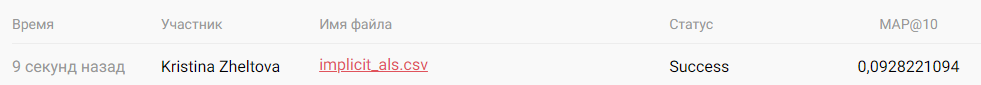

### LightFM

In [ ]:
def objective_LightFMWrapperModel(trial):
    n_factors = trial.suggest_int("n_factors", low=32, high=128, step=32)
    loss = trial.suggest_categorical("loss", choices=['logistic', 'bpr', 'warp'])
    lr = trial.suggest_float("lr", low=0.05, high=0.25, step=0.05)
    item_alpha = trial.suggest_float("item_alpha", low=0.0, high=0.1, step=0.05)
    user_alpha = trial.suggest_float("item_alpha", low=0.0, high=0.1, step=0.05)

    model_obj = LightFMWrapperModel(
      model=LightFM(
        no_components=n_factors, 
        loss=loss, 
        random_state=SEED,
        learning_rate=lr,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
      ),
      epochs=2,
      num_threads=1,
    )

    model_obj.fit(dataset)
    recos = model_obj.recommend(
      users=TEST_USERS,
      dataset=dataset,
      k=K_RECOS,
      filter_viewed=True,
    )
    metric_values = calc_metrics(metrics, recos, test, train)

    return metric_values['map@10'], metric_values['recall@10']

In [ ]:
def save_best_trial_model(trial):
    # Use same code objective to reproduce the best model
    n_factors = trial.suggest_int("n_factors", low=32, high=128, step=32)
    loss = trial.suggest_categorical("loss", choices=['logistic', 'bpr', 'warp'])
    lr = trial.suggest_float("lr", low=0.05, high=0.25, step=0.05)
    item_alpha = trial.suggest_float("item_alpha", low=0.0, high=0.1, step=0.05)
    user_alpha = trial.suggest_float("item_alpha", low=0.0, high=0.1, step=0.05)

    model_obj = LightFMWrapperModel(
      model=LightFM(
        no_components=n_factors, 
        loss=loss, 
        random_state=SEED,
        learning_rate=lr,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
      ),
      epochs=3,
      num_threads=1,
    )

    model_obj.fit(dataset)

    with open('lightfm.dill', 'wb') as f:
      dill.dump(model_obj.model, f)

In [ ]:
%%time

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(objective_LightFMWrapperModel, n_trials=10)

[I 2022-12-03 14:43:08,017] A new study created in memory with name: no-name-4eb36191-5d9f-4148-b135-67ae31d616a6
[I 2022-12-03 14:45:55,842] Trial 0 finished with values: [0.08192788774082765, 0.17559389481428675] and parameters: {'n_factors': 32, 'loss': 'warp', 'lr': 0.05, 'item_alpha': 0.1}. 
[I 2022-12-03 14:48:32,030] Trial 1 finished with values: [0.057390103587612436, 0.11485589995710924] and parameters: {'n_factors': 32, 'loss': 'warp', 'lr': 0.1, 'item_alpha': 0.1}. 
[I 2022-12-03 14:52:50,587] Trial 2 finished with values: [0.0003676267437634818, 0.001102979447741638] and parameters: {'n_factors': 64, 'loss': 'logistic', 'lr': 0.1, 'item_alpha': 0.1}. 
[I 2022-12-03 14:55:01,055] Trial 3 finished with values: [0.00040315926647058837, 0.0009623803721536533] and parameters: {'n_factors': 32, 'loss': 'logistic', 'lr': 0.15000000000000002, 'item_alpha': 0.0}. 
[I 2022-12-03 15:03:52,871] Trial 4 finished with values: [0.08042141895515426, 0.17016015189823552] and parameters: {'n

CPU times: user 52min 21s, sys: 8min 45s, total: 1h 1min 6s
Wall time: 45min 42s


In [ ]:
print_study_info(study)

Number of finished trials:  10
Best trial:
  Params: 
    n_factors: 32
    loss: warp
    lr: 0.05
    item_alpha: 0.1


In [ ]:
study.best_trials

[FrozenTrial(number=0, values=[0.08192788774082765, 0.17559389481428675], datetime_start=datetime.datetime(2022, 12, 3, 14, 43, 8, 20019), datetime_complete=datetime.datetime(2022, 12, 3, 14, 45, 55, 842660), params={'n_factors': 32, 'loss': 'warp', 'lr': 0.05, 'item_alpha': 0.1}, distributions={'n_factors': IntDistribution(high=128, log=False, low=32, step=32), 'loss': CategoricalDistribution(choices=('logistic', 'bpr', 'warp')), 'lr': FloatDistribution(high=0.25, log=False, low=0.05, step=0.05), 'item_alpha': FloatDistribution(high=0.1, log=False, low=0.0, step=0.05)}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)]

In [ ]:
save_best_trial_model(study.best_trials[0])

In [ ]:
with open('lightfm.dill', 'rb') as f:
    assert type(dill.load(f)) == LightFM

#### Fit best model & submit

In [ ]:
recs = pd.DataFrame({'user_id': submission['user_id'].unique()})
cold = recs[~recs['user_id'].isin(dataset.user_id_map.external_ids)]
warm = recs[recs['user_id'].isin(dataset.user_id_map.external_ids)]
cold.head()

,user_id
2,29
4,33
5,39
11,70
12,74


In [ ]:
model_obj = LightFMWrapperModel(
  model=LightFM(
    no_components=32, 
    loss='warp', 
    random_state=SEED,
    learning_rate=0.05,
    user_alpha=0.1,
    item_alpha=0.1,
  ),
  epochs=2,
  num_threads=1,
)

model_obj.fit(dataset)

In [ ]:
recos = model_obj.recommend(
  users=warm['user_id'].values,
  dataset=dataset,
  k=K_RECOS,
  filter_viewed=True,
).drop(['score', 'rank'], axis=1).groupby('user_id').agg({'item_id': list}).reset_index()
recos.head()

,user_id,item_id
0,3,"[15297, 13865, 6809, 4740, 7102, 9996, 1844, 1..."
1,11,"[10440, 9728, 13865, 4151, 142, 3734, 2657, 48..."
2,30,"[15297, 10440, 13865, 4151, 6809, 142, 3734, 2..."
3,46,"[15297, 9728, 13865, 4151, 6809, 3734, 2657, 1..."
4,47,"[15297, 10440, 9728, 4151, 6809, 142, 3734, 26..."


In [ ]:
cold_recs = [[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734] for i in range(len(cold['user_id']))]
cold_recs = pd.DataFrame(list(zip(cold['user_id'].values.tolist(), cold_recs)), columns=['user_id', 'item_id'])
cold_recs.head()

,user_id,item_id
0,29,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."
1,33,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."
2,39,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."
3,70,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."
4,74,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."


In [ ]:
res = pd.concat((cold_recs, recos))
assert res.shape[0] == submission.shape[0]
res.to_csv('lightfm.csv', index=False)

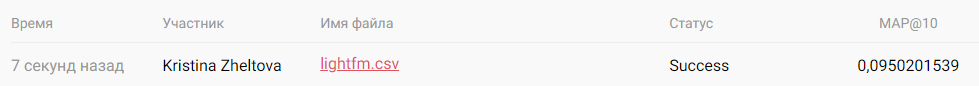